# Deep Text Project 

**Description:**
propose at least 2 models to predict new dinosaurs names.

- model 1: n-grams langage model
- model 2: deep learning model

Author: Karl SOP

In [42]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from collections import namedtuple, deque
from string import ascii_lowercase
from tensorflow.keras.utils import plot_model

# Utils

In [43]:
import pathlib
import os

def create_path_if_not_exist(path: str) -> None:
    """
    Create if exists missing directory in a path to a file
    :param path: A file path
    :return:
    """
    dir_path, file = os.path.split(path)
    # Create missing directory in the path
    pathlib.Path(dir_path).mkdir(parents=True, exist_ok=True)

In [44]:
save_plot_dir = "plots/"
create_path_if_not_exist(save_plot_dir)

## Importing Data

In [45]:
def import_data(file_path):
    lines = io.open(file_path, encoding='UTF-8').read().strip().split('\n')
    return np.array(lines)

In [46]:
data = import_data("data/dinos.txt")

In [47]:
data.shape

(1536,)

## Data Exploration

In [48]:
df = pd.DataFrame(data, columns=["name"])
df.head()

,name
0,Aachenosaurus
1,Aardonyx
2,Abdallahsaurus
3,Abelisaurus
4,Abrictosaurus


In [49]:
df["name_len"] = df["name"].apply(lambda x: len(x))
df.head()

,name,name_len
0,Aachenosaurus,13
1,Aardonyx,8
2,Abdallahsaurus,14
3,Abelisaurus,11
4,Abrictosaurus,13


In [50]:
df["name_len"].describe()

count    1536.00000
mean       11.96224
std         2.49714
min         3.00000
25%        10.00000
50%        12.00000
75%        13.00000
max        26.00000
Name: name_len, dtype: float64

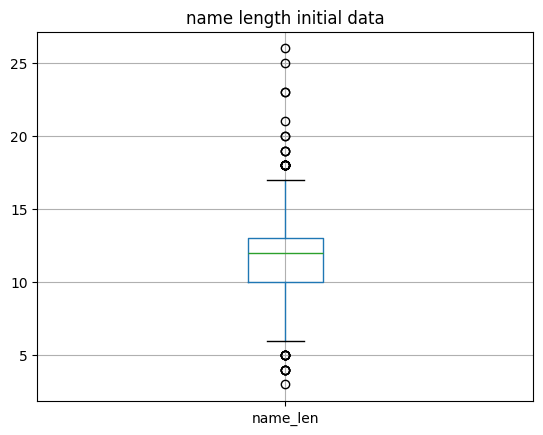

In [51]:
fig, ax = plt.subplots()
bp = df.boxplot(column=["name_len"])
ax.set_title("name length initial data")
fig.savefig(os.path.join(save_plot_dir, "initial_data_name_length.svg"), format="svg")
plt.show()

We see that we have 1536 dinosaurs names in our dataset with a mean length of 12 characters with a standrad deviation of 2.5. We also see that the mean ~ to the median in this case which is 12. So 50% of the names of our datase have names length in [3, 12] and 50% of the names in our database have names length in [10, 13]. From the boxplot we see that name length in [3, 5] and [17, 26] are outliers. 

All these factors suggest that if we set a size limit of 35 characters on the names of the dinosaurs we are going to generate, we will have made a realistic choice.

## Preprocessing

In [52]:
data = np.char.lower(data)

In [53]:
data = np.unique(data)

In [54]:
SpecialToken = namedtuple("SpecialToken", ["start", "end"])
special_token = SpecialToken(
    "<START>",
    "<END>"
)

## First Model N-grams

In [55]:
def create_word_index_unigram(special_token: SpecialToken) -> tuple[dict[str, int], np.ndarray]:
    """
        Generate all unigrams
        :param special_token: a namedtuple with all the special token
        :return a dict mapping letter to integer and a list mapping it indices to a letter
    """
    word_to_index = {
        (special_token.start, ): 0,
        (special_token.end, ): 1
    }
    index_to_word = [special_token.start, special_token.end]
    i = 2
    for letter in ascii_lowercase:
        word_to_index[letter] = i
        index_to_word.append(letter)
        i += 1

    return word_to_index, index_to_word


def create_word_index_n_gram(n: int, text: np.ndarray, special_token: SpecialToken) -> tuple[dict[str, int], np.ndarray]:
    """
        Generate all n_gram
        :param n: an integer representing the n in n_gram
        :param text: a ndarray holding the dataset of dinosaurs names
        :param special_token: a namedtuple with all the special token
        :return a dict mapping n_gram to integer and a list mapping it indices to n_gram
    """
    word_to_index = {
        (special_token.start, ) * n: 0,
        (special_token.end,): 1
    }
    index_to_word = [special_token.start * n, special_token.end]
    j = len(index_to_word)
    curr_n_gram = deque(maxlen=n)
    for sent in text:
        for _ in range(n-1):
            curr_n_gram.append(special_token.start)
        for i in range(len(sent)):
            curr_n_gram.append(sent[i])
            word = tuple(curr_n_gram)
            if word not in index_to_word:
                # word_to_index[word] = len(index_to_word)
                word_to_index[word] = j
                index_to_word.append(word)
                j += 1
    return word_to_index, index_to_word

In [56]:
def create_n_gram_matrix(n: int, text: np.ndarray, special_token: SpecialToken, word_to_index: dict[str, int], index_to_word: np.ndarray, letter_to_index: dict[str, int]) -> np.ndarray:
    """
        Generate the frequency matrix of letter given an n-gram
        :param n: an integer representing the n in n_gram
        :param text: The ndaary of word
        :param special_token: a namedtuple with all the special token
        :param word_to_index: a dict mapping all the n_gram to an integer
        :param index_to_word: a ndarray mapping his index to n_gram
        :param letter_to_index: a dict mapping all the letter (unigram) to an integer

        :return the frequency matrix of letter given an n-gram
    """
    
    index_to_word_len = len(index_to_word)
    letter_len = len(letter_to_index)
    matrix = np.zeros((index_to_word_len, letter_len))
    curr_ngram = deque(maxlen=n)
    
    for word in text:
        curr_ngram.clear()
        for _ in range(n):
            curr_ngram.append(special_token.start)
        word_len = len(word)
        for i in range(word_len+1):
            w = tuple(curr_ngram)
            if i == 0:
                matrix[word_to_index[w], letter_to_index[word[0]]] += 1
                curr_ngram.append(word[i])
            elif i == word_len:
                pass
                # w = " ".join(word[start_index:i])
                # matrix[word_to_index[w], letter_to_index[special_token.end]] += 1
            else:
                # w = (special_token.start + " ") * (n-i) + " ".join(word[start_index:i])
                matrix[word_to_index[w], letter_to_index[word[i]]] += 1
                curr_ngram.append(word[i])
        matrix[word_to_index[w], letter_to_index[(special_token.end,)]] += 1
    return matrix

In [57]:
def get_next_letter(k: int , matrix: np.ndarray, n_gram_ind: int, index_to_letter: np.ndarray, verbose: int = 0) -> str:
    """
        Get the next letter after the current n_gram.
        Select a random letter between the k max element with non-zero probability

        :param k: the size of the pool from which we select a random letter
        :param matrix: a probability/freq matrix of a letter given an n_gram
        :param n_gram_ind: the indice of the n_gram in the frequency/probability matrix
        :param index_to_letter: a numpy array mapping integer (indices) to a letter
        :param verbose: if 1 print more information that can be used to debug

        :return the indice and the letter associated
    """
    line = matrix[n_gram_ind]
    ind = np.argpartition(line, -k)[-k:]
    new_ind = []
    letters = []
    for i in ind:
        if line[i] > 0:
            new_ind.append(i)
            letters.append(index_to_letter[i])
    new_ind = np.array(new_ind)
    if verbose:
        print("random choice between: {}, with prob: {}".format(letters, np.take(line, new_ind)))
    ind_choosed = np.random.choice(new_ind)
    return ind_choosed, index_to_letter[ind_choosed]

In [58]:
def generate_name_n_grams(n: int, special_token: SpecialToken, word_to_index: dict[str, int], index_to_letter: np.ndarray, matrix: np.ndarray, max_letter_num: int = 35) -> str:
    """
        Generate a dinosaur name
        :param n: the n in n_gram
        :param special_token: a namedtuple with all the special token
        :param word_to_index: a dict mapping all the n_gram to an integer
        :param index_to_letter: a numpy array mapping integer (indices) to a letter
        :param matrix: a probability/freq matrix of a letter given an n_gram
        :return a string representing a dinosaur name
    """
    k = 5
    w = []
    curr_ngram = deque(maxlen=n)
    for _ in range(n):
        curr_ngram.append(special_token.start)
    word = []
    for i in range(max_letter_num):
        w = tuple(curr_ngram)
        ind_n_gram = word_to_index[w]
        _, letter = get_next_letter(k, matrix, ind_n_gram, index_to_letter)
        if letter == special_token.end:
            break
        word.append(letter)
        curr_ngram.append(letter)
    word = "".join(word)
    return word

In [59]:
def generate_n_names(names_num: int, n: int, special_token: SpecialToken) -> list[str]:
    """
        Generate n dinosaurs names

        :param names_num: number of name to generate
        :param n: the n in n_gram
        :param special_token: a namedtuple with all the special token
        :return a list of generated names
    """
    names = []
    letter_to_index, index_to_letter = create_word_index_unigram(special_token)
    word_to_index, index_to_word = create_word_index_n_gram(n, data, special_token)
    freq_matrix = create_n_gram_matrix(n, data, special_token, word_to_index, index_to_word, letter_to_index)
    for i in range(names_num):
        names.append(
            generate_name_n_grams(n, special_token, word_to_index, index_to_letter, freq_matrix).capitalize()
        )
    return names

In [60]:
result_n_gram = {}

In [61]:
n = 1
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Ptisa',
 'Anithatitia',
 'Tesicas',
 'Auruatatitinorua',
 'Tichona',
 'Phoniasican',
 'Sta',
 'Phusua',
 'Pesisusuna',
 'Sititodriatiauca']

In [62]:
n = 2
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Canstanseindasuchuanotylursodcrurst',
 'Amacrutegasasustracrypodryx',
 'Arcumarocole',
 'Tops',
 'Chon',
 'Tocelleyasauracosasstarsodeirangata',
 'Conodryphadasiatishonocumatiaon',
 'Celusing',
 'Pricelucindubicran',
 'Cangan']

In [63]:
n = 3
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Chonasus',
 'Stoscelishanops',
 'Aura',
 'Calamphyshamopusacisivosauraparalos',
 'Auronotosphenopcosuccinocauhcernuso',
 'Tethysaltonychodosuchondylosphilano',
 'Petonykus',
 'Centopusacianssus',
 'Shetri',
 'Tracisaura']

In [64]:
n = 4
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Trachilantorapterostroracervixosaur',
 'Siatosauros',
 'Triunfosauraechingkankousaurikornit',
 'Patagonykus',
 'Argyrosaurutitanius',
 'Segisauraechinornis',
 'Sinus',
 'Ammosaicerasauroracervixosaurutitan',
 'Timurlengopterosterrholophoneus',
 'Creosaurophalangia']

In [65]:
n = 5
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Silesaurushypacroscelus',
 'Ampelosaura',
 'Pelorosaurides',
 'Comahuesaurushypacrosauravus',
 'Stokesosauriscus',
 'Polyonax',
 'Segisauruskol',
 'Camarasuchus',
 'Silesauruskol',
 'Pleuropasaurornithomimus']

In [66]:
n = 6
num = 100
result_n_gram[n] = generate_n_names(num, n, special_token)
result_n_gram[n][:10]

['Tototlmimus',
 'Strenusauruskol',
 'Sinraptorsaurus',
 'Stereocephalus',
 'Tethyshadrosauravus',
 'Alioramus',
 'Cerasinops',
 'Prenoceratosaurusliubangosaurusliub',
 'Shenzhousaurus',
 'Aucasaurus']

## Result Analysis

In [67]:
df_gen_name_n_gram = pd.DataFrame(data=result_n_gram)
df_gen_name_n_gram.head()

,1,2,3,4,5,6
0,Ptisa,Canstanseindasuchuanotylursodcrurst,Chonasus,Trachilantorapterostroracervixosaur,Silesaurushypacroscelus,Tototlmimus
1,Anithatitia,Amacrutegasasustracrypodryx,Stoscelishanops,Siatosauros,Ampelosaura,Strenusauruskol
2,Tesicas,Arcumarocole,Aura,Triunfosauraechingkankousaurikornit,Pelorosaurides,Sinraptorsaurus
3,Auruatatitinorua,Tops,Calamphyshamopusacisivosauraparalos,Patagonykus,Comahuesaurushypacrosauravus,Stereocephalus
4,Tichona,Chon,Auronotosphenopcosuccinocauhcernuso,Argyrosaurutitanius,Stokesosauriscus,Tethyshadrosauravus


In [68]:
df_gen_name_n_gram["name_len_1_gram"] = df_gen_name_n_gram[1].apply(lambda x: len(x))
df_gen_name_n_gram["name_len_2_gram"] = df_gen_name_n_gram[2].apply(lambda x: len(x))
df_gen_name_n_gram["name_len_3_gram"] = df_gen_name_n_gram[3].apply(lambda x: len(x))
df_gen_name_n_gram["name_len_4_gram"] = df_gen_name_n_gram[4].apply(lambda x: len(x))
df_gen_name_n_gram["name_len_5_gram"] = df_gen_name_n_gram[5].apply(lambda x: len(x))
df_gen_name_n_gram["name_len_6_gram"] = df_gen_name_n_gram[6].apply(lambda x: len(x))
df_gen_name_n_gram.head()

,1,2,3,4,5,6,name_len_1_gram,name_len_2_gram,name_len_3_gram,name_len_4_gram,name_len_5_gram,name_len_6_gram
0,Ptisa,Canstanseindasuchuanotylursodcrurst,Chonasus,Trachilantorapterostroracervixosaur,Silesaurushypacroscelus,Tototlmimus,5,35,8,35,23,11
1,Anithatitia,Amacrutegasasustracrypodryx,Stoscelishanops,Siatosauros,Ampelosaura,Strenusauruskol,11,27,15,11,11,15
2,Tesicas,Arcumarocole,Aura,Triunfosauraechingkankousaurikornit,Pelorosaurides,Sinraptorsaurus,7,12,4,35,14,15
3,Auruatatitinorua,Tops,Calamphyshamopusacisivosauraparalos,Patagonykus,Comahuesaurushypacrosauravus,Stereocephalus,16,4,35,11,28,14
4,Tichona,Chon,Auronotosphenopcosuccinocauhcernuso,Argyrosaurutitanius,Stokesosauriscus,Tethyshadrosauravus,7,4,35,19,16,19


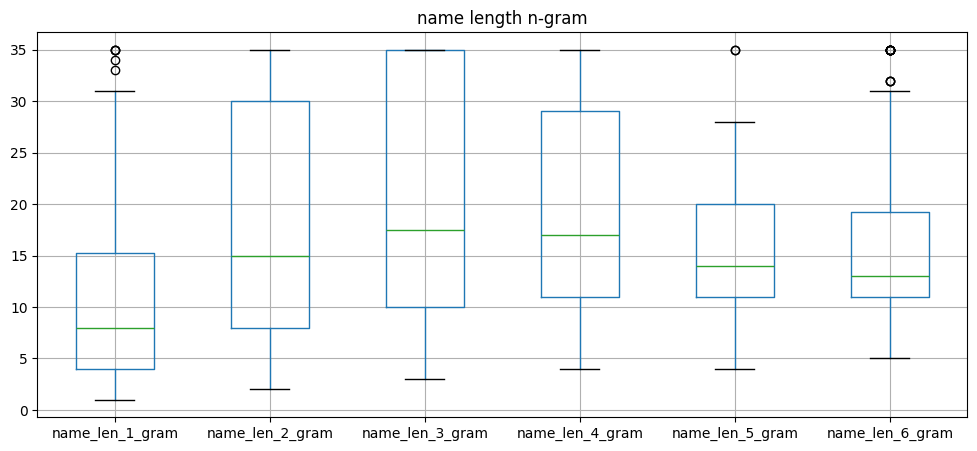

In [69]:
fig, ax = plt.subplots(figsize=(12,5))
bp = df_gen_name_n_gram.boxplot(column=["name_len_1_gram", "name_len_2_gram", "name_len_3_gram", "name_len_4_gram", "name_len_5_gram", "name_len_6_gram"])
ax.set_title("name length n-gram")
fig.savefig(os.path.join(save_plot_dir, "n_gram_name_length.svg"), format="svg")
plt.show()

In [70]:
df_gen_name_n_gram["name_len_1_gram"].describe()

count    100.000000
mean      11.180000
std        9.182086
min        1.000000
25%        4.000000
50%        8.000000
75%       15.250000
max       35.000000
Name: name_len_1_gram, dtype: float64

In [71]:
df_gen_name_n_gram["name_len_2_gram"].describe()

count    100.000000
mean      17.700000
std       11.392448
min        2.000000
25%        8.000000
50%       15.000000
75%       30.000000
max       35.000000
Name: name_len_2_gram, dtype: float64

In [72]:
df_gen_name_n_gram["name_len_3_gram"].describe()

count    100.000000
mean      20.670000
std       11.856086
min        3.000000
25%       10.000000
50%       17.500000
75%       35.000000
max       35.000000
Name: name_len_3_gram, dtype: float64

In [73]:
df_gen_name_n_gram["name_len_4_gram"].describe()

count    100.000000
mean      19.050000
std        9.773573
min        4.000000
25%       11.000000
50%       17.000000
75%       29.000000
max       35.000000
Name: name_len_4_gram, dtype: float64

In [74]:
df_gen_name_n_gram["name_len_5_gram"].describe()

count    100.000000
mean      15.410000
std        6.215157
min        4.000000
25%       11.000000
50%       14.000000
75%       20.000000
max       35.000000
Name: name_len_5_gram, dtype: float64

In [75]:
df_gen_name_n_gram["name_len_6_gram"].describe()

count    100.000000
mean      16.450000
std        8.571005
min        5.000000
25%       11.000000
50%       13.000000
75%       19.250000
max       35.000000
Name: name_len_6_gram, dtype: float64

- For unigram (1-gram) 50% of the generated name length are in [4, 16]
- For bigram (2-gram) 50% of the generated name length are in [8, 32]
- For trigram (3-gram) 50% of the generated name length are in [12, 35]
- For (4-gram) 50% of the generated name length are in [9, 23]
- For (5-gram) 50% of the generated name length are in [11, 17]
- For (6-gram) 50% of the generated name length are in [10, 25]

The n-gram models implemented doesn't learn the statistical effect in the original dataset never nevertheless 5-gram and 6-gram seemsto be giving good results.

We observe that unigram and bigrams doesn't give us good results, we suspect that it is due to the lack of context. Unigram only use previous letter and bigram use 2 letters at position i-1 and i-2.

We also observe that the model tend to be better with the increase of n. n = 5 and n = 6 give believable names.

## Model 2: Deep Learning Model

**Description of training process:**

We have a dataset of dinosaur name, to train a deep learning model to generate new name we will split dinosaur name in sequence of length __seq_len__ and train our model to predict the next letter of the sequence. Example if we take the dinosaur name __Aachenosaurus__ and a __seq_len__ = 6 we will split it in ['\<START>aache', 'aachen',  'acheno', 'chenos', 'henosa', 'enosau', 'nosaur', 'osauru', 'saurus'] and our y will be ['n', 'o', 's', 'a', 'u', 'r', 'u', 's', '\<END>']

We add the special token \<START> and \<END> so that the model learn their special meaning when we give \<START> to a model it will start generating a sequence and \<END> means it has finish generating a sequence

In [76]:
def add_special_token(special_token: SpecialToken, data: np.ndarray) -> np.ndarray:
    """
        Add Special token to all lines in data
        :param special_token: a namedtuple with all the special token
        :param data: ndarray holding the lines to which we will add the special_tokens
        :return ndarray holding the modified lines 
    """
    def add_start_and_end(lines):
        result = []
        for line in lines:
            result.append(special_token.start + line + special_token.end)
        return result
    return np.apply_along_axis(add_start_and_end, 0, data)

In [77]:
def generate_letter_to_index(special_token: SpecialToken) -> tuple[dict[str, int], np.ndarray]:
    """
        :param special_token: a namedtuple with all the special token
        :return a dict mapping letter to integer and a list mapping it indices to a letter
    """
    word_to_index = {
        special_token.start: 0,
        special_token.end: 1
    }
    index_to_word = [special_token.start, special_token.end]
    i = 2
    for letter in ascii_lowercase:
        word_to_index[letter] = i
        index_to_word.append(letter)
        i += 1

    return word_to_index, index_to_word

In [78]:
def build_model(num_labels, vocab_len, embedding_size, dropout_rate):
    inputs = tf.keras.layers.Input(shape=(None,) )
    x = tf.keras.layers.Embedding(vocab_len, embedding_size)(inputs)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, return_sequences=False)
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(75, activation="relu")(x)
    output = tf.keras.layers.Dense(num_labels, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [79]:
char_to_idx, idx_to_char = generate_letter_to_index(special_token)   

In [80]:
def build_sequence(seq_len :int, data:np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    sequences = []
    next_chars = []
    for name in data:
        name_len = len(name)
        for i in range(name_len - seq_len + 2):
            if i == 0:
                sequences.append(special_token.start + name[:i + seq_len - 1])
                if name_len + 1 == seq_len:
                    next_chars.append(special_token.end)
                    break
                next_chars.append(name[i + seq_len - 1])
            elif i == name_len - seq_len + 1:
                sequences.append(name[i - 1:])
                next_chars.append(special_token.end)
            else:
                sequences.append(name[i - 1: i + seq_len - 1])
                next_chars.append(name[i + seq_len - 1])
    sequences = np.array(sequences)
    next_chars = np.array(next_chars)
    return sequences, next_chars

In [81]:
# sequences, next_chars = build_sequence(6, data)
# sequences[:10]

In [82]:
 # next_chars[:10]

In [83]:
# We construct our training dataset
def convert_seq_to_dataset(sequences: np.ndarray, next_chars: np.ndarray, char_to_idx: dict[str, int]) -> tuple[np.ndarray, np.ndarray]:
    """
        Construction of our training dataset
    """
    
    X = []
    for seq in sequences:
        new_seq = seq
        word = []
        end = False
        if special_token.start in seq:
            new_seq = seq[7:]
            word.append(char_to_idx[special_token.start])
        if special_token.end in seq:
            new_seq = seq[:-5]
            end = True
        for char in new_seq:
            word.append(char_to_idx[char])
        if end:
            word.append(char_to_idx[special_token.end])
        X.append(word)
    X = np.array(X)
    y = np.array([char_to_idx[char] for char in next_chars])
    return X, y

In [84]:
def build_dataset(seq_len, data, char_to_idx):
    sequences, next_chars = build_sequence(seq_len, data)
    X, y = convert_seq_to_dataset(sequences, next_chars, char_to_idx)
    return X, y

In [85]:
seq_len = 6
X, y = build_dataset(seq_len, data, char_to_idx)
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (12134, 6)
y shape:  (12134,)


In [86]:
X[:5]

array([[ 0,  2,  2,  4,  9,  6],
       [ 2,  2,  4,  9,  6, 15],
       [ 2,  4,  9,  6, 15, 16],
       [ 4,  9,  6, 15, 16, 20],
       [ 9,  6, 15, 16, 20,  2]])

In [87]:
y[:5]

array([15, 16, 20,  2, 22])

In [88]:
embedding_size = 10
dropout_rate = 0.2
vocab_len = len(idx_to_char)
label_num = len(idx_to_char)
model = build_model(label_num, vocab_len, embedding_size, dropout_rate)
model.compile(
    optimizer="adam",
    metrics =["accuracy"], 
    loss="sparse_categorical_crossentropy"
    
)

I0000 00:00:1730249785.957070  666828 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 01:56:25.958196: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


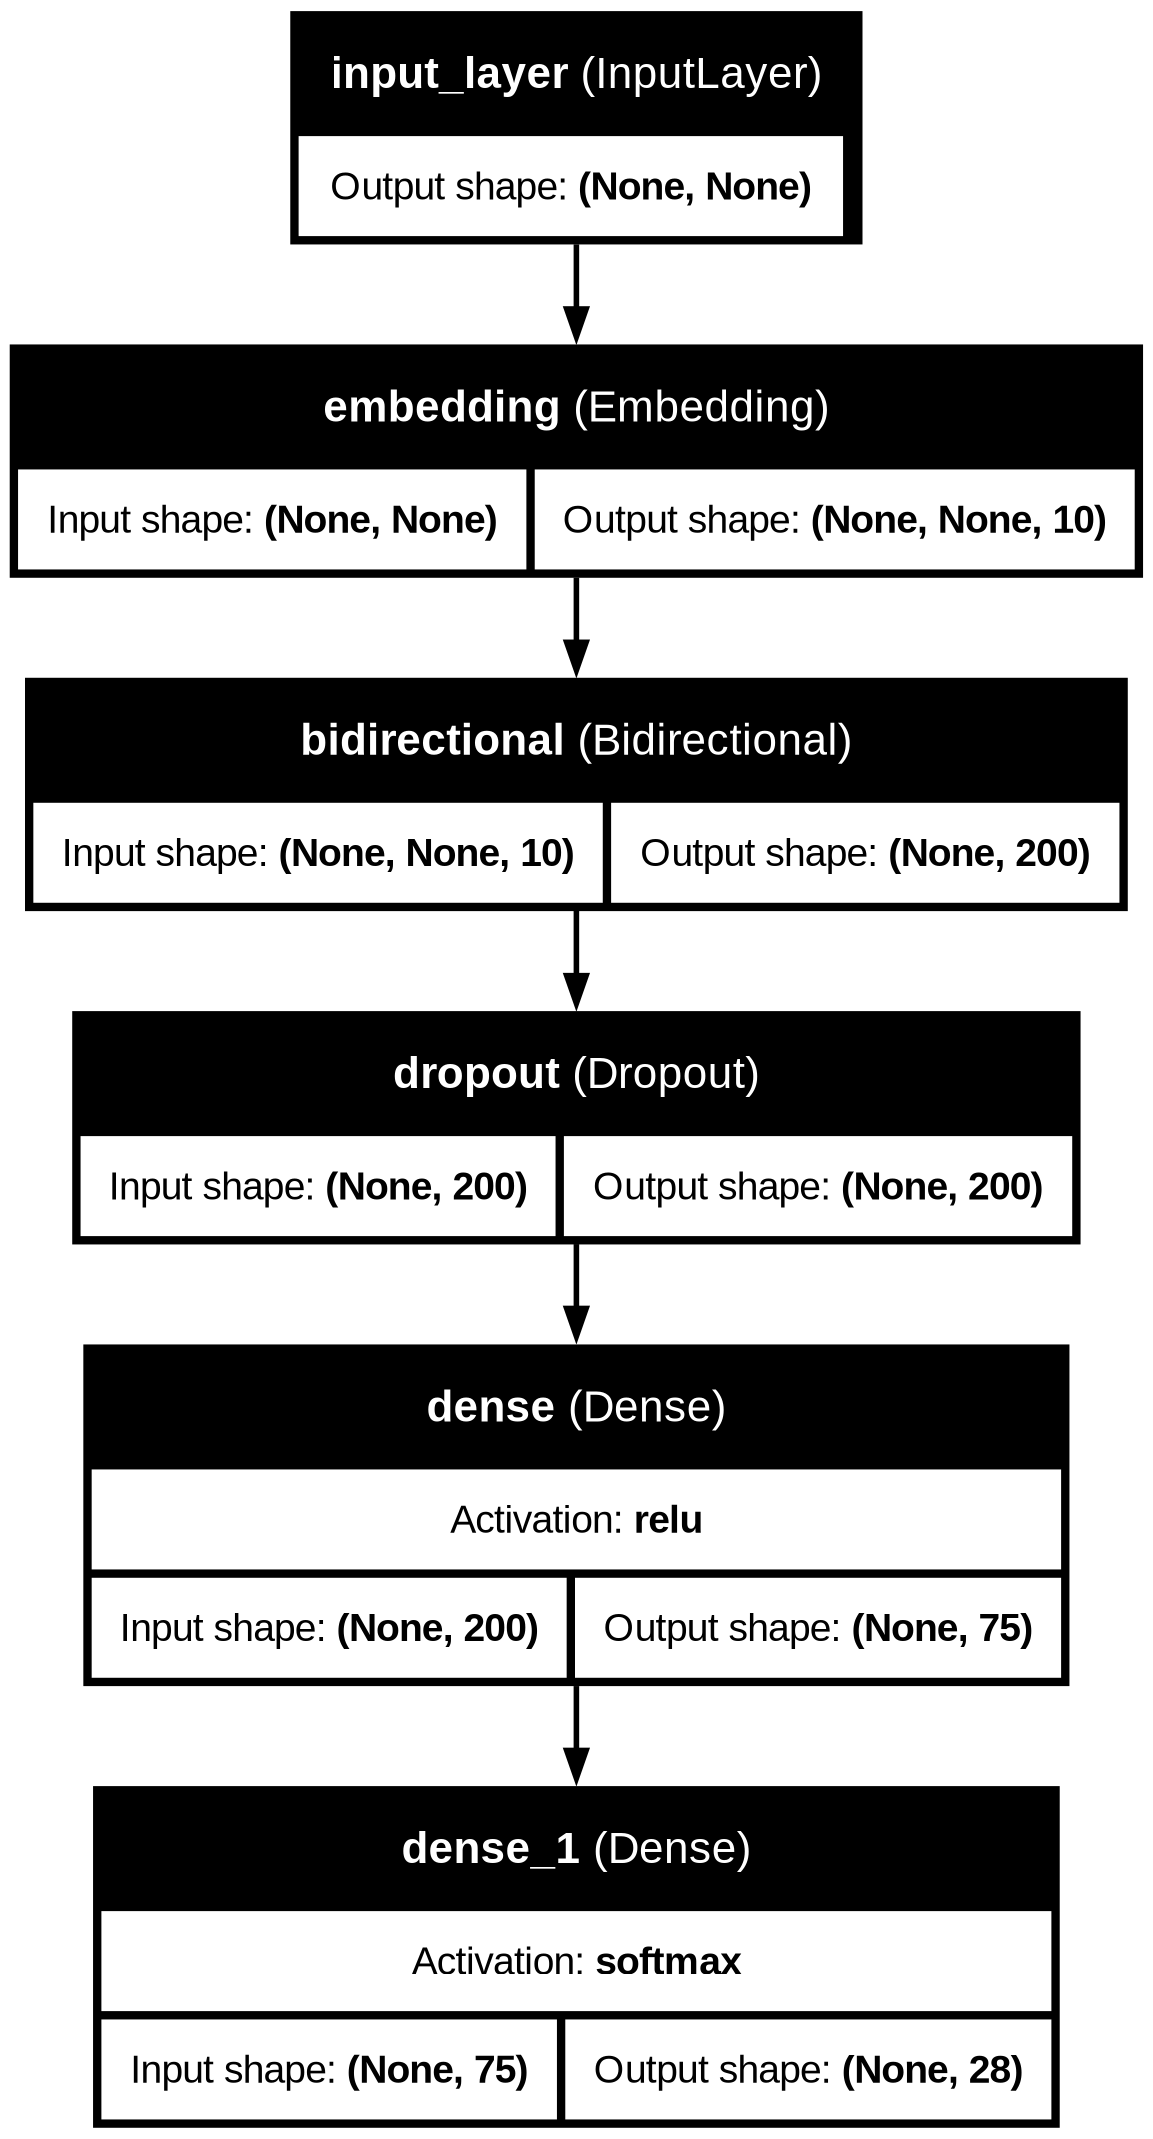

In [89]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    to_file = os.path.join(save_plot_dir, "deep_learning_model_structure.png")
)

In [90]:
epochs = 80
batch_size = 64

In [91]:
callbacks = [
    # To try to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=20,
        mode="max",
        restore_best_weights=True,
        start_from_epoch=0
    )
]
history = model.fit(
    X, 
    y, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_split = 0.2, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/80


152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1629 - loss: 2.8293 - val_accuracy: 0.2806 - val_loss: 2.3091
Epoch 2/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3594 - loss: 2.1340 - val_accuracy: 0.4850 - val_loss: 1.8261
Epoch 3/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5251 - loss: 1.6818 - val_accuracy: 0.4994 - val_loss: 1.6718
Epoch 4/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5279 - loss: 1.6006 - val_accuracy: 0.5126 - val_loss: 1.5985
Epoch 5/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5493 - loss: 1.5127 - val_accuracy: 0.5480 - val_loss: 1.5606
Epoch 6/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5717 - loss: 1.4586 - val_accuracy: 0.5459 - val_loss: 1.5243
Epoch 7/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5719 - loss: 1.4516 - val_accuracy: 0.5620 - val_loss: 1.4876
Epoch 8/80
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5879 - loss: 1.4038 - val_accuracy: 0.567

In [92]:
# save model
save_weights_path = "./model/model.weights.h5"
# model.save_weights(save_weights_path)

In [120]:
# Load model
model.load_weights(save_weights_path)

In [94]:
def plot(history): # It's always the same function.
    # @Author: M. Rivelli Unica
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    fig.savefig(os.path.join(save_plot_dir, "training_history.svg"), format="svg")
    plt.show()

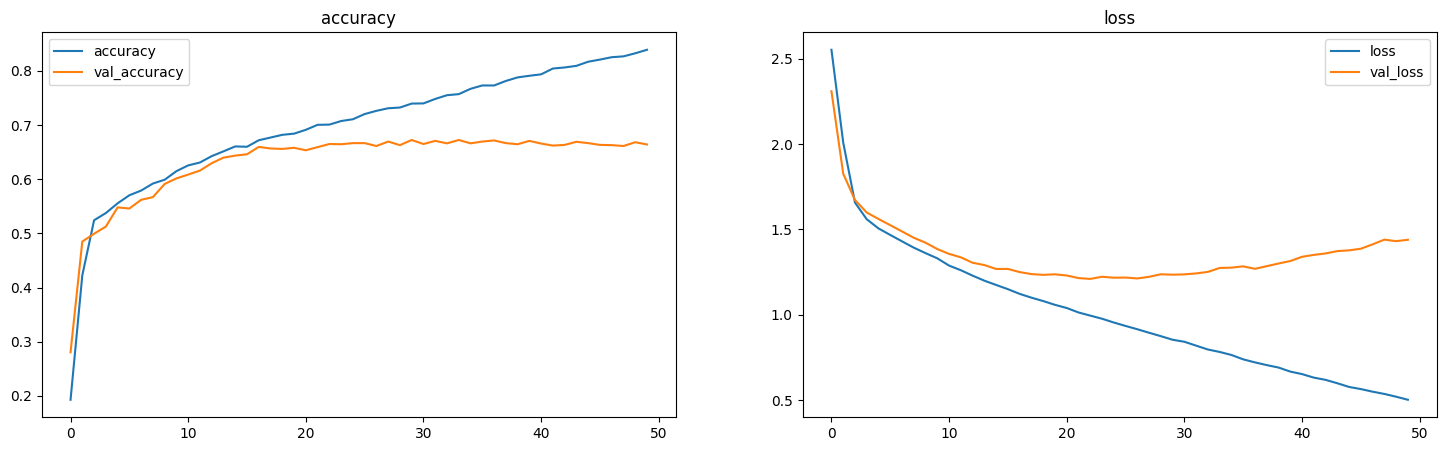

In [95]:
plot(history.history)

**Description of name generation:**

1. At the start we have a sequence with only the token \<START>. 
2. To start generating we give our sequence to the model. The model will produce probabilities associated to each letter to be the next. From this pool we select randomly one letter using the probabilities given by the model. 
3. We add the selected letter to the sequence and we feed the last __sequence_length__ characters to our model.
4. We repeat step 2 and 3 until the model produce the token \<END> or the maximum size of our name is reached

In [121]:
def generate_dinosaur_name(label_num: int, special_token: SpecialToken, model, seq_len: int, seed_name: list[str] = [], max_len: int = 35) -> str:
    """
        generate dinosaur name
        :param label_num: an int representing the number of labels
        :param special_token: a namedtuple with all the special token
        :param model: the tf model to use to generate the name
        :param seq_len: the length of the sequence to use
        :param seed_name: the initial sequence
        :param max_len: the max length of a generated name 
        :return a string representing a dinosaur name
    """
    name = [special_token.start]
    if seed_name != []:
        name = seed_name
    for _ in range(max_len):
        sequence = np.array([[char_to_idx[char] for char in name[-seq_len:]]])
        predictions = model.predict(sequence.reshape(1, -1), verbose=0)[0]
        next_char_index = np.random.choice(label_num, p=predictions)
        next_char = idx_to_char[next_char_index]

        # Break if <END> token is predicted
        if next_char == special_token.end:
            break
        name.append(next_char)
    name = "".join(name)
    # Clean up the output by removing <START> token and capitalizing
    return name.replace(special_token.start, "").capitalize()

In [123]:
name_num_to_generate = 100
gen_names = []
for _ in range(name_num_to_generate):
    gen_names.append(generate_dinosaur_name(label_num, special_token, model, seq_len))

In [124]:
print("\n".join(gen_names[:10]))

Drodon
Hoarasaurus
Lrrtucnisaurus
Ervortontomia
Irgtaia
Topaltasaura
Oahophyrathoteransor
Osaurus
Oisaurus
Itoszdon


In [125]:
def postprocessing(names: list[str]) -> tuple[np.ndarray, dict[str, int]]:
    auth_suffix = ["saurus", "raptor", "ceratops", "mimus", "titan", "pelta", "pteryx", "venator", "long", "therium", "cyon", "pithecus", "cetus", "erpeton", "suchus", "pter", "pterus", "ella", "omorpha", "oidea", "idae", "inae", "ini"]
    regex = re.compile("({})$".format("|".join(auth_suffix)), re.IGNORECASE)
    plausible_names = []
    suffix_count = {"other": 0}
    for suffix in auth_suffix:
        suffix_count[suffix] = 0
    for name in names:
        m = regex.search(name)
        if m:
            plausible_names.append(name)
            suffix_count[m.group()] += 1
        else:
            suffix_count["other"] += 1
    plausible_names = np.array(plausible_names)
    return plausible_names, suffix_count

In [126]:
plausible_names, suffix_count = postprocessing(gen_names)

## Result Analysis

In [127]:
def plot_suffix_count(suffix_count: dict[str, int]):
    keys = list(suffix_count.keys())
    count = []
    for key in keys:
        count.append(suffix_count[key])
    fig, ax = plt.subplots(figsize=(18, 5)) 
    ax.bar(keys, count)
    ax.set_ylabel('frequency')
    ax.set_title('suffix')
    ax.legend(title='frequency per existing suffix for generated names (deep learning)')
    fig.savefig(os.path.join(save_plot_dir, "frequency_per_existing_suffix_deep_learning_generated_names.svg"), format="svg")
    plt.show()

In [128]:
df_deep_gen = pd.DataFrame(gen_names, columns=["name"])
df_deep_gen["name_len"] = df_deep_gen["name"].apply(lambda x: len(x))
df_deep_gen.head()

,name,name_len
0,Drodon,6
1,Hoarasaurus,11
2,Lrrtucnisaurus,14
3,Ervortontomia,13
4,Irgtaia,7


In [129]:
df_deep_gen_postprocessed = pd.DataFrame(plausible_names, columns=["name"])
df_deep_gen_postprocessed["name_len"] = df_deep_gen_postprocessed["name"].apply(lambda x: len(x))
df_deep_gen_postprocessed.head()

,name,name_len
0,Hoarasaurus,11
1,Lrrtucnisaurus,14
2,Osaurus,7
3,Oisaurus,8
4,Oriasimosaurus,14


In [130]:
df.describe()

,name_len
count,1536.00000
mean,11.96224
std,2.49714
min,3.00000
25%,10.00000
50%,12.00000
75%,13.00000
max,26.00000


In [131]:
df_deep_gen.describe()

,name_len
count,100.00000
mean,10.66000
std,3.69608
min,0.00000
25%,8.00000
50%,10.00000
75%,12.25000
max,22.00000


In [132]:
df_deep_gen_postprocessed.describe()

,name_len
count,63.000000
mean,11.349206
std,2.829332
min,7.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,20.000000


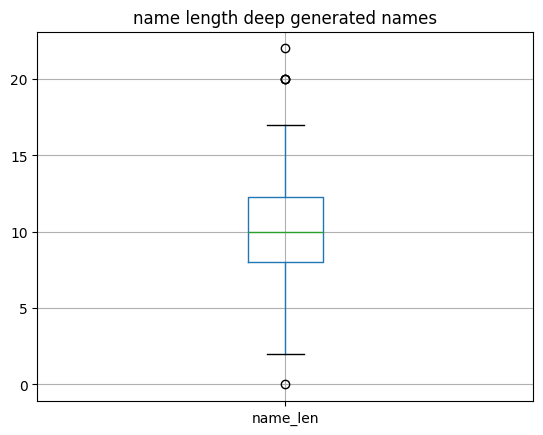

In [133]:
fig, ax = plt.subplots()
bp = df_deep_gen.boxplot(column=["name_len"])
ax.set_title("name length deep generated names")
fig.savefig(os.path.join(save_plot_dir, "deep_generated_name_length.svg"), format="svg")
plt.show()

/tmp/ipykernel_666828/1754604432.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='frequency per existing suffix for generated names (deep learning)')


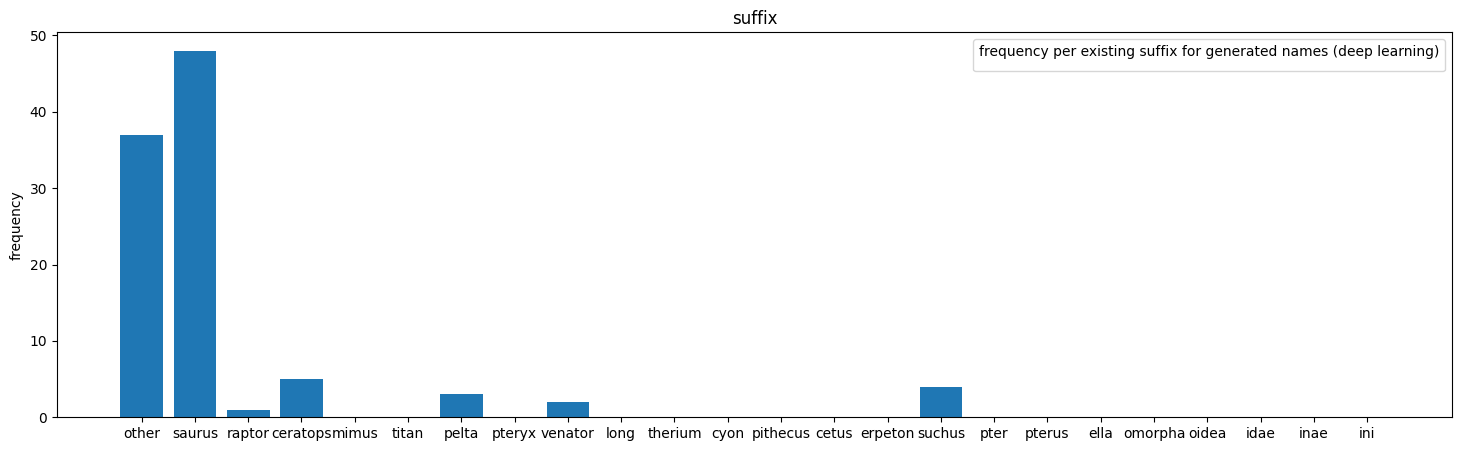

In [134]:
plot_suffix_count(suffix_count)

Here we have generated 100 new names and we see that 50% of generated name length is in [8, 13] which is close to the [10, 13] of the original dataset. We also have the mean length that is close to the median length like in the original dataset. Despite the low number of generated example, the model manages to reproduce statistical effect in initial dataset

After postprocessing of the generated names we have about ~64% remaining. Our processing consists of removal of names with non international agreement suffix but we can't move them to bin because these result can give us new suffix that add to the agreement. 50% of the postprocessed names length are in [9, 13] which is close to the [10, 13] of the original dataset.

From the plot above we can see that ~50% of generated names have suffix saurus and ~35% have suffix that are not in the international agreement of dinosaur names.

# Conclusion

We have reach the end of this project. This project was to generate new dinosaurs names given a dataset of existing dinosaur name.

1. First we try to do that using n_grams we saw that unigram (1_gram) and bigram (2_gram) had poor performance. It could be due to the fact that the lack context respectively using only previous letter or 2 previous letter. We also saw that 5_gram and 6_gram give us plausible names.

2. Secondly we design and train a deep learning model to generate the names. We took inspiration on n_grams. In n_gram we select the next letter based on the probability given the n previous letter. This probability was in a custom matrix. We replaced the matrix here by a deep learning model. Using a sequence length of 6 like in the 6_grams give us better result that the n_gram counterpart. We also have additional benefit the deep learning model generalize in case he haven't see during training or with the hand-crafted matrix if we haven't see a case we have a risk of not knowing what to do

# Playing with the deep learning model

In [138]:
# Here you can modify param seed_name to give a list of char representing the initial sequence for the model
generate_dinosaur_name(label_num, special_token, model, seq_len, seed_name=[special_token.start, "k", "a", "r", "l"])

'Karlongatholimus'

# References

[1] Medium, Code Diaries: Text Prediction (n-grams), https://medium.com/analytics-vidhya/code-diaries-text-prediction-n-grams-e3aa4d5325a2

[2] Medium, NLP : Génération de texte par n-grams, https://beranger.medium.com/nlp-génération-de-texte-par-n-grams-3894187f6cd4

[3] Medium, N-grams in NLP, https://medium.com/@abhishekjainindore24/n-grams-in-nlp-a7c05c1aff12

[4] Obscure Dinosaur Facts, https://obscuredinosaurfacts.com/blog/post/2019/09/05/dinosaur-word-roots.html